# Неделя 4. Сравнение алгоритмов классификации

In [1]:
%reload_ext watermark
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn,seaborn,tqdm -g

CPython 3.7.2
IPython 7.2.0

numpy 1.15.4
scipy 1.2.0
pandas 0.23.4
matplotlib 3.0.2
statsmodels 0.9.0
sklearn 0.20.2
seaborn 0.9.0
tqdm 4.28.1

compiler   : Clang 6.0 (clang-600.0.57)
system     : Darwin
release    : 18.5.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit
Git hash   : 13254b8efd76cdd0ceefc3bc1756dee1b0d29dee


In [2]:
import csv
from collections import Counter, defaultdict
from functools import lru_cache
from itertools import count, product
from pathlib import Path
from typing import Iterable, List, Tuple, TypeVar
from warnings import catch_warnings, simplefilter

import numpy
import seaborn
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from scipy.sparse import csr_matrix
from tqdm import tqdm_notebook

%matplotlib inline
seaborn.set(rc={'figure.figsize': (16, 6)})

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

Загрузим сериализованные ранее объекты `X_sparse_10users` и `y_10users`, соответствующие обучающей выборке для 10 пользователей.

In [3]:
T = TypeVar('T')


def windowed(iterable: Iterable[T], *, n: int, step: int) -> Iterable[List[T]]:
    iterable = list(iterable)
    for offset in range(0, len(iterable), step):
        yield iterable[offset:offset + n]

In [4]:
@lru_cache(None)
def prepare_train_set(
    path: Path, 
    session_length: int = 10,
    window_size: int = 10,
) -> Tuple[csr_matrix, numpy.ndarray]:
    user_sessions: List[Tuple[int, Counter]] = [
        (int(csv_path.stem[-4:]), Counter(session))
        for csv_path in tqdm_notebook(sorted(path.glob('*.csv')), desc='CSVs')
        for session in windowed(
            (row['site'] for row in csv.DictReader(csv_path.open('rt'))),
            n=session_length,
            step=window_size,
        )
    ]
    
    site_ids = defaultdict(count().__next__)
        
    x = csr_matrix((
        [value for _, session in user_sessions for value in session.values()],  # values are visit counts
        (
            [i for i, (_, session) in enumerate(user_sessions) for value in session.values()],  # row indices are session numbers
            [site_ids[site] for _, session in user_sessions for site in session],  # column indices are site IDs
        ),
    ))
    y = numpy.array([user_id for user_id, _ in user_sessions])
    
    return x, y

In [5]:
x_10users, y_10users = prepare_train_set(Path('10users'))

Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.

In [6]:
x_10users.shape

(14061, 4913)

Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.

In [69]:
x_train, x_test, y_train, y_test = train_test_split(
    x_10users, y_10users, test_size=0.3, random_state=17, stratify=y_10users)

Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр `random_state=17` – для воспроизводимости.

In [8]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Вспомогательная функция для отрисовки кривых валидации после запуска `GridSearchCV` (или `RandomizedCV`).

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = pyplot.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = pyplot.plot(param_values, valid_mu, '-', label='test', color='red')
    pyplot.fill_between(
        param_values,
        train_mu - train_std,
        train_mu + train_std,
        edgecolor='none',
        facecolor=train_line[0].get_color(),
        alpha=0.2,
    )
    pyplot.fill_between(
        param_values,
        valid_mu - valid_std,
        valid_mu + valid_std,
        edgecolor='none',
        facecolor=valid_line[0].get_color(),
        alpha=0.2,
    )
    pyplot.legend()

Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs=-1` для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.

In [10]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
score_1 = cross_val_score(knn, x_train, y_train, cv=cv, n_jobs=-1).mean()
score_2 = accuracy_score(y_test, knn.fit(x_train, y_train).predict(x_test))

**Вопрос 1.** Посчитайте доли правильных ответов для `KNeighborsClassifier` на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.

In [11]:
Path('answer4_1.txt').write_text(f'{score_1:.3f} {score_2:.3f}')
!cat answer4_1.txt

0.565 0.584

Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state=17`). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score=True`) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.

In [12]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1).fit(x_train, y_train)

**Вопрос 2.** Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.

In [13]:
score_2 = accuracy_score(y_test, forest.predict(x_test))

In [14]:
Path('answer4_2.txt').write_text(f'{forest.oob_score_:.3f} {score_2:.3f}')
!cat answer4_2.txt

0.723 0.735

Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state=17` (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.

In [15]:
lr = LogisticRegression(random_state=17, solver='liblinear', multi_class='ovr')
score_1 = cross_val_score(lr, x_train, y_train, cv=cv, n_jobs=-1).mean()
score_2 = accuracy_score(y_test, lr.fit(x_train, y_train).predict(x_test))

In [16]:
print(f'{score_1:.3f} {score_2:.3f}')

0.761 0.782


С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от `1e-4` до `1e2`, используйте `logspace` из NumPy. Укажите у `LogisticRegressionCV` параметры `multi_class='multinomial'` и `random_state=17`. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.

In [17]:
with catch_warnings():
    simplefilter('ignore')
    lrcv = LogisticRegressionCV(
        Cs=numpy.logspace(-4, 2, 10),
        multi_class='multinomial',
        random_state=17,
        cv=cv,
    ).fit(x_train, y_train)

Нарисуйте кривые валидации по параметру `C`.

In [18]:
# How?

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [19]:
# How?

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [20]:
lrcv.C_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [21]:
# How?

Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace(0.1, 7, 20)`. Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.

In [70]:
with catch_warnings():
    simplefilter('ignore')
    lrcv2 = LogisticRegressionCV(
        Cs=numpy.linspace(0.1, 7, 20),
        multi_class='multinomial',
        random_state=17,
        cv=cv,
    ).fit(x_train, y_train)

In [71]:
lrcv2.C_

array([0.46315789, 0.46315789, 0.46315789, 0.46315789, 0.46315789,
       0.46315789, 0.46315789, 0.46315789, 0.46315789, 0.46315789])

In [91]:
# Best C for question 4.7. That's what the author meant. See also the thread:
# https://www.coursera.org/learn/data-analysis-project/discussions/weeks/4/threads/JAJbeSdfEeeuuQ7tmHEh3A/replies/znOrHgqSEeihiRLMG3w3WA
scores, *_ = lrcv2.scores_.values()
_, best_c_47 = numpy.unravel_index(scores.argmax(), scores.shape)
C_47 = lrcv2.Cs_[best_c_47]

**Вопрос 3**. Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.

In [24]:
lr.C = 0.46315789
score_1 = cross_val_score(lr, x_train, y_train, cv=cv, n_jobs=-1).mean()
score_2 = accuracy_score(y_test, lr.fit(x_train, y_train).predict(x_test))

In [25]:
Path('answer4_3.txt').write_text(f'{score_1:.3f} {score_2:.3f}')
!cat answer4_3.txt

0.756 0.773

Обучите линейный SVM (`LinearSVC`) с параметром `C=1` и `random_state=17` (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.

In [26]:
svc = LinearSVC(C=1.0, random_state=17)
score_1 = cross_val_score(svc, x_train, y_train, cv=cv, n_jobs=-1).mean()
score_2 = accuracy_score(y_test, svc.fit(x_train, y_train).predict(x_test))
print(f'{score_1:.3f} {score_2:.3f}')

0.753 0.777


/Users/eigenein/GitHub/mipt-ya-ml-spec/venv/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.

In [27]:
grid_search = GridSearchCV(
    svc,
    {'C': numpy.linspace(1e-4, 1e4, 10)},
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
).fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    3.9s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    7.8s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.2s finished
/Users/eigenein/GitHub/mipt-ya-ml-spec/venv/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [28]:
grid_search.best_params_

{'C': 7777.777800000001}

In [29]:
grid_search.best_score_

0.6879699248120301

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

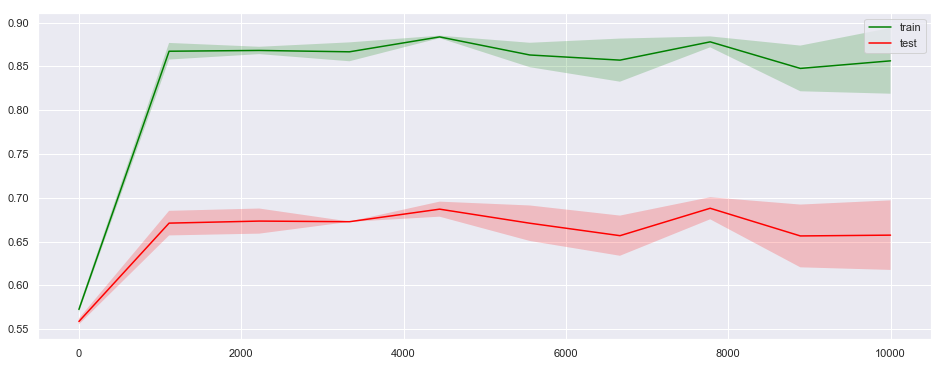

In [30]:
plot_validation_curves(grid_search.param_grid['C'], grid_search.cv_results_)

Но мы помним, что с параметром регуляризации по умолчанию (`С=1`) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`.

С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне `(1e-3, 1)`, 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.

In [31]:
grid_search = GridSearchCV(
    svc,
    {'C': numpy.linspace(1e-3, 1, 30)},
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
).fit(x_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  90 | elapsed:    2.4s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.1s finished


In [32]:
grid_search.best_score_, grid_search.best_params_

(0.764681975208291, {'C': 0.10434482758620689})

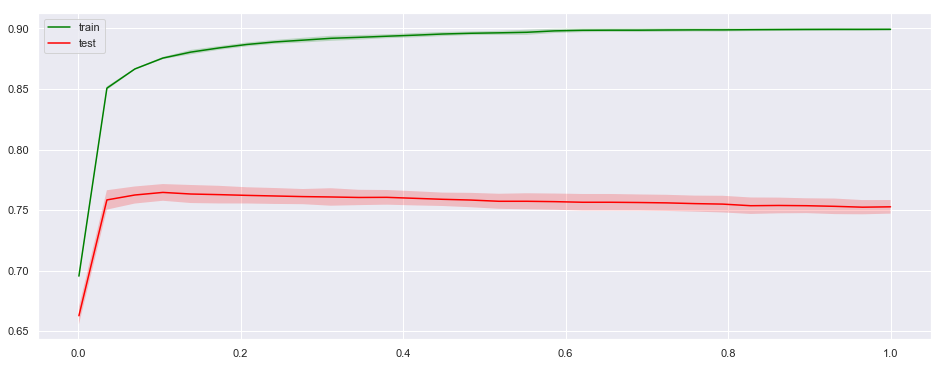

In [33]:
plot_validation_curves(grid_search.param_grid['C'], grid_search.cv_results_)

**Вопрос 4.** Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.

In [34]:
score_2 = accuracy_score(y_test, grid_search.best_estimator_.predict(x_test))

In [35]:
Path('answer4_4.txt').write_text(f'{grid_search.best_score_:.3f} {score_2:.3f}')
!cat answer4_4.txt

0.765 0.781

## Часть 2. Выбор параметров – длины сессии и ширины окна

Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров `session_length` и `window_size`). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.

Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.

In [36]:
svc = grid_search.best_estimator_
print(svc)

LinearSVC(C=0.10434482758620689, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
     tol=0.0001, verbose=0)


In [37]:
def assess_model(estimator, path: Path, session_length: int, window_size: int, random_state=17, test_size=0.3):
    x, y = prepare_train_set(path, session_length=session_length, window_size=window_size)
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=random_state, stratify=y)
    score_1 = cross_val_score(estimator, x_train, y_train, cv=cv, n_jobs=-1).mean()
    estimator.fit(x_train, y_train)
    score_2 = accuracy_score(y_test, estimator.predict(x_test))
    return score_1, score_2

Убедитесь, что функция работает.

In [38]:
assess_model(svc, Path('10users'), session_length=10, window_size=10)

(0.7646853244550981, 0.7807537331121118)

Примените функцию `model_assessment` для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров `session_length` и `window_size` для 10 пользователей. Выведите в цикле параметры `session_length` и `window_size`, а также результат вывода функции `model_assessment`. Удобно сделать так, чтоб `model_assessment` возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.

In [39]:
for window_size, session_length in tqdm_notebook(product([10, 7, 5], [15, 10, 7, 5]), desc='Assessment'):
    if window_size <= session_length:
        score_1, score_2 = assess_model(
            svc, Path('10users'), session_length=session_length, window_size=window_size)
        print(f'Session: {session_length}. Window: {window_size}. Score 1: {score_1:.3f}. Score 2: {score_2:.3f}.')

Session: 15. Window: 10. Score 1: 0.824. Score 2: 0.840.
Session: 10. Window: 10. Score 1: 0.765. Score 2: 0.781.


Session: 15. Window: 7. Score 1: 0.848. Score 2: 0.854.


Session: 10. Window: 7. Score 1: 0.797. Score 2: 0.807.


Session: 7. Window: 7. Score 1: 0.753. Score 2: 0.762.


Session: 15. Window: 5. Score 1: 0.868. Score 2: 0.875.


Session: 10. Window: 5. Score 1: 0.816. Score 2: 0.825.


Session: 7. Window: 5. Score 1: 0.774. Score 2: 0.785.


Session: 5. Window: 5. Score 1: 0.725. Score 2: 0.736.



**Вопрос 5.** Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.

In [40]:
Path('answer4_5.txt').write_text('0.868 0.875');

Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров `(session_length, window_size)`: `(5,5)`, `(7,7)` и `(10,10)`. На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :)

Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.

In [41]:
for window_size, session_length in tqdm_notebook([(5, 5), (7, 7), (10, 10)], desc='Assessment'):
    if window_size <= session_length:
        score_1, score_2 = assess_model(
            svc, Path('150users'), session_length=session_length, window_size=window_size)
        print(f'Session: {session_length}. Window: {window_size}. Score 1: {score_1:.3f}. Score 2: {score_2:.3f}.')

Session: 5. Window: 5. Score 1: 0.409. Score 2: 0.422.


Session: 7. Window: 7. Score 1: 0.436. Score 2: 0.453.


Session: 10. Window: 10. Score 1: 0.461. Score 2: 0.484.



In [42]:
Path('answer4_6.txt').write_text('0.461 0.484');

## Часть 3. Идентификация конкретного пользователя и кривые обучения

Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо.

Загрузим сериализованные ранее объекты `X_sparse_150users` и `y_150users`, соответствующие обучающей выборке для 150 пользователей с параметрами `(session_length, window_size)` = `(10,10)`. Так же точно разобьем их на 70% и 30%.

In [96]:
x_150users, y_150users = prepare_train_set(Path('150users'))
x_train, x_test, y_train, y_test = train_test_split(
    x_150users, y_150users, test_size=0.3, random_state=17, stratify=y_150users)

Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class='ovr'`. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state=17`.

In [97]:
%%time
lr = LogisticRegressionCV(random_state=17, multi_class='ovr', Cs=[C_47], n_jobs=-1, cv=cv)
with catch_warnings():
    simplefilter('ignore')
    lr.fit(x_train, y_train)

CPU times: user 22min 20s, sys: 10min 25s, total: 32min 46s
Wall time: 5min 6s


Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.

In [98]:
for user_id, scores in lr.scores_.items():
    print(f'User {user_id}, CV score: {scores.mean()}')

User 6, CV score: 0.9960795612888451
User 13, CV score: 0.996392603416394
User 15, CV score: 0.99526648227745
User 16, CV score: 0.9919507613560473
User 28, CV score: 0.9901787659762019
User 31, CV score: 0.9942968989054074
User 33, CV score: 0.9936505040113687
User 39, CV score: 0.9858620830655959
User 46, CV score: 0.997987857444965
User 49, CV score: 0.9952773284622092
User 50, CV score: 0.9944638280683459
User 53, CV score: 0.9935982902101794
User 65, CV score: 0.9968513700582928
User 66, CV score: 0.994765980924795
User 82, CV score: 0.9964030122764157
User 85, CV score: 0.9962987207688639
User 89, CV score: 0.9905225842610896
User 92, CV score: 0.9942033320079174
User 100, CV score: 0.9945575257465724
User 102, CV score: 0.9913986089935877
User 103, CV score: 0.9805449611891582
User 105, CV score: 0.996934881144005
User 106, CV score: 0.9946719103641056
User 118, CV score: 0.990929076551474
User 119, CV score: 0.9966116229096368
User 120, CV score: 0.9943177074194115
User 126, CV

Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в `y_train_150`, отличных от ID этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером i в задаче классификации i-vs-All).

In [99]:
n_class_samples = numpy.bincount(y_train.astype('int'))
n_better_than_default = (numpy.array([
    scores.mean() - (1.0 - n_class_samples[user_id] / len(y_train))
    for user_id, scores in lr.scores_.items()
]) > 0).sum()
answer = n_better_than_default / len(lr.scores_)

**Вопрос 7.** Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.

In [100]:
Path('answer4_7.txt').write_text(f'{answer:.3f}');
%cat answer4_7.txt

0.820